## Running the Model

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 26 10:21:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
BASE_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140'

In [0]:
import os
from datetime import datetime
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (25,20)
plt.rcParams.update({'font.size': 12})


import torch
import torch.optim as optim

os.chdir(os.path.join(BASE_PATH, 'agent1'))

import numpy as np
import pandas as pd

from lib import data, environ, models

from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [0]:
EPSILON = 0.02
# EPSILON = 0.0

# TEST_DATA_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/YNDX/YNDX_160101_161231.csv'
# TEST_DATA_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/YNDX/YNDX_150101_151231.csv'
# TEST_DATA_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/BTCUSD/COINBASE_BTCUSD, 1.csv'
test_data_paths = {
    # 'BTCUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/BTCUSD/COINBASE_BTCUSD, 1.csv',
    # 'BTCUSD2': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/BTCUSD/GEMINI_BTCUSD, 1 (1).csv',
    # 'BTCEUR': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/BTCEUR/COINBASE_BTCEUR, 1 (1).csv',
    # 'BCHUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/BCHUSD/KRAKEN_BCHUSD, 1 (1).csv',
    # 'EOSUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/EOSUSD/KRAKEN_EOSUSD, 1 (1).csv',
    # 'LTCUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/LTCUSD/KRAKEN_LTCUSD, 1 (1).csv',
    # 'XMRUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/XMRUSD/KRAKEN_XMRUSD, 1 (1).csv',
    # 'XRPEUR': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/XRPEUR/KRAKEN_XRPEUR, 1 (1).csv',
    # 'XRPUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/XRPUSD/KRAKEN_XRPUSD, 1 (1).csv',
    'ETHEUR': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/ETHEUR/1+2.csv',
    # 'XTZUSD': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/XTZUSD/KRAKEN_XTZUSD, 1 (1).csv',
    # 'YNDX15': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/YNDX/YNDX_150101_151231.csv',
    # 'YNDX16': '/content/drive/My Drive/NTNU/6. Semester/NEURO140/Data/1M/YNDX/YNDX_160101_161231.csv',
}

# MODEL_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/agent1/crypto-saves/test-6.4-crypto-agent-small/fullmodel-33.data'
# MODEL_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/agent1/crypto-saves/test-6.2-crypto-agent-2/fullmodel-29.data'
MODEL_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/agent1/crypto-saves/test-7.1-crypto-agent-1/fullmodel-19.data'
# MODEL_PATH = '/content/drive/My Drive/NTNU/6. Semester/NEURO140/agent1/crypto-saves/test-7.2-crypto-agent-1/fullmodel-19.data'
DQNConv1DLarge = models.DQNConv1DLarge1

BARS = 50
RESET_ON_CLOSE = False
RANDOM_OFS_ON_RESET = False
REWARD_ON_CLOSE = True
STATE_1D = True
# Remember to turn this to true when using LARGE=False
LARGE = True
VOLUMES = not LARGE

# COMMISSION = 0.1
# COMMISSION = 0.02
COMMISSION = 0.0

OUTPUT_NAME = f'C-Agent-7.1, com-{COMMISSION}, pairs-{"-".join(test_data_paths.keys())}'

In [0]:
test_data, test_data_dfs = data.get_data_as_dict(
    test_data_paths,
    large=LARGE,
    get_dfs=True,
)

In [0]:
reward_dict = {}

In [56]:
env = environ.StocksEnv(
    test_data,
    bars_count=BARS,
    reset_on_close=RESET_ON_CLOSE,
    commission=COMMISSION,
    state_1d=STATE_1D,
    random_ofs_on_reset=RANDOM_OFS_ON_RESET,
    reward_on_close=REWARD_ON_CLOSE,
    volumes=VOLUMES,
    large=LARGE,
)

# Load a full saved net
net = torch.load(MODEL_PATH)
net.eval()

rewards_all_runs = []
replicates = 10
for i in range(replicates):
    print(f"Starting replicate {i + 1}")
    
    obs = env.reset()
    start_price = env._state._cur_close()

    total_reward = 0.0
    step_idx = 0
    rewards = []
    num_pos = 0
    invested = False
    buy_idxs = []
    sell_idxs = []

    while True:
        step_idx += 1
        obs_v = torch.tensor([obs], device=device)
        out_v = net(obs_v)
        action_idx = out_v.max(dim=1)[1].item()
        if np.random.random() < EPSILON:
            action_idx = env.action_space.sample()
        action = environ.Actions(action_idx)

        if action == environ.Actions.Buy:
            if not invested:
                buy_idxs.append(step_idx)
            invested = True
        elif action == environ.Actions.Close:
            if invested == True:
                sell_idxs.append(step_idx)
                num_pos += 1
            invested = False

        obs, reward, done, _ = env.step(action_idx)
        
        total_reward += reward
        rewards.append(total_reward)
        if step_idx % 1000 == 0:
            print(f"{step_idx}: reward={total_reward:.3f}, number of positions={num_pos}")
        if done:
            break
    
    rewards_all_runs.append(np.array(rewards))
    print()

code = 'agent-7.1'
reward_dict[code] = {
    "name": f"Large network 1, large feature set (code: {code}) [mean of {replicates} tests]",
    "rewards": np.array(rewards_all_runs).mean(axis=0),
}

Starting replicate 1
1000: reward=2.092, number of positions=7
2000: reward=6.330, number of positions=17
3000: reward=7.178, number of positions=23
4000: reward=7.830, number of positions=26
5000: reward=8.156, number of positions=30
6000: reward=10.510, number of positions=37
7000: reward=6.063, number of positions=40
8000: reward=8.225, number of positions=51
9000: reward=7.544, number of positions=59
10000: reward=6.122, number of positions=68
11000: reward=6.781, number of positions=72
12000: reward=8.068, number of positions=78
13000: reward=6.291, number of positions=80
14000: reward=6.720, number of positions=88
15000: reward=6.231, number of positions=89
16000: reward=6.628, number of positions=92
17000: reward=7.365, number of positions=97
18000: reward=7.766, number of positions=110
19000: reward=8.487, number of positions=117
20000: reward=9.094, number of positions=121
21000: reward=9.581, number of positions=124
22000: reward=11.045, number of positions=133
23000: reward=

<Figure size 1800x1440 with 0 Axes>

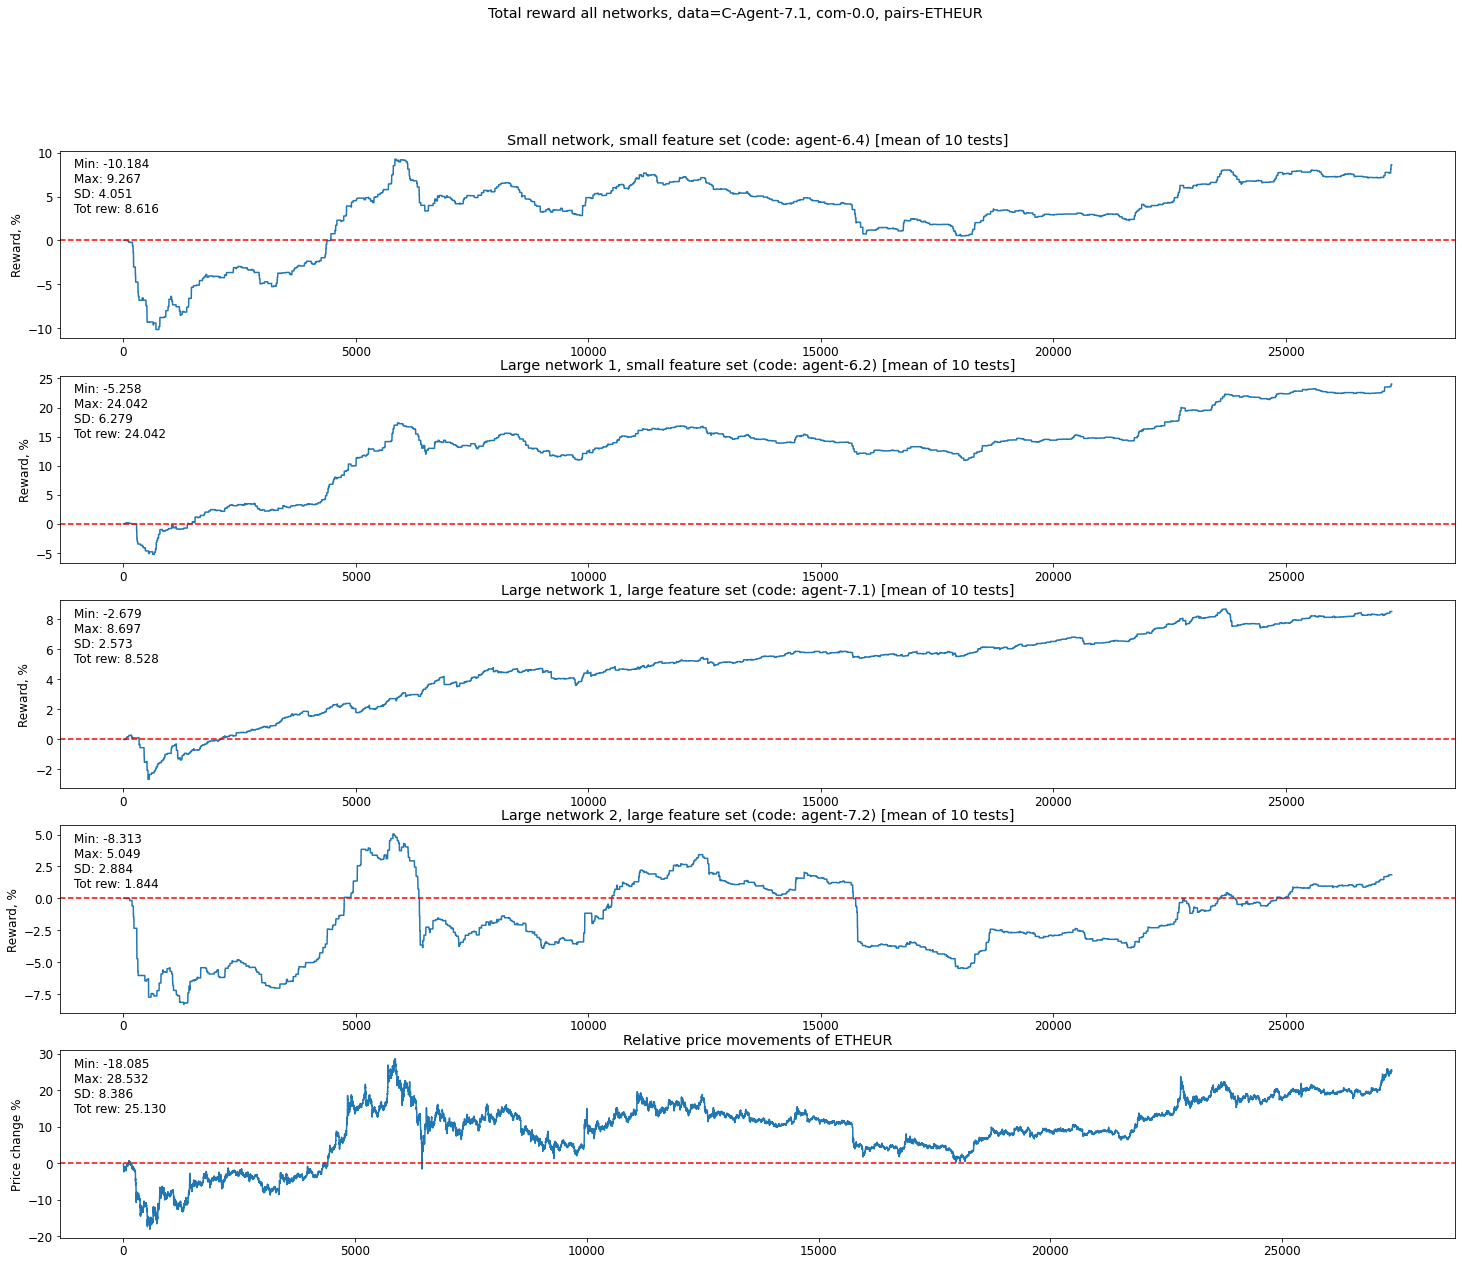

In [71]:
# Plot one large graph with all networks in it
reward_dict = {
    'agent-6.4': reward_dict['agent-6.4'],
    'agent-6.2': reward_dict['agent-6.2'],
    'agent-7.1': reward_dict['agent-7.1'],
    'agent-7.2': reward_dict['agent-7.2'],
}

def get_info_text(data):
    return (f"Min: {np.min(data):.3f}\n"
        + f"Max: {np.max(data):.3f}\n"
        + f"SD: {np.sqrt(np.var(data)):.3f}\n"
        + f"Tot rew: {data[-1]:.3f}")


plt.clf()
rew_len = len(reward_dict)

fig, axs = plt.subplots(rew_len + 1);

fig.suptitle(f"Total reward all networks, data={OUTPUT_NAME}")

for i, (code, run) in enumerate(reward_dict.items()):
    axs[i].plot(run['rewards'])
    axs[i].axhline(y=0, linestyle='--', color='r')
    axs[i].set(ylabel="Reward, %", title=run["name"])

    infotxt = get_info_text(run['rewards'])

    axs[i].text(0.01, 0.67, infotxt, size=12, 
         transform=axs[i].transAxes)

df = list(test_data_dfs.values())[0]
df_rel = df.copy()
df_rel['close'] = 100 * (df_rel['close'] - df_rel['open'].iloc[0]) / df_rel['open'].iloc[0]

axs[rew_len].plot(df_rel['close'], zorder=-1)
axs[rew_len].set(ylabel="Price change %", title="Relative price movements of ETHEUR")
axs[rew_len].axhline(y=0, linestyle='--', color='r')

infotxt = get_info_text(np.array(df_rel['close']))

axs[rew_len].text(0.01, 0.67, infotxt, size=12, 
        transform=axs[rew_len].transAxes);

plt.savefig(f"all-networks-{datetime.now()}.png");

<Figure size 1800x720 with 0 Axes>

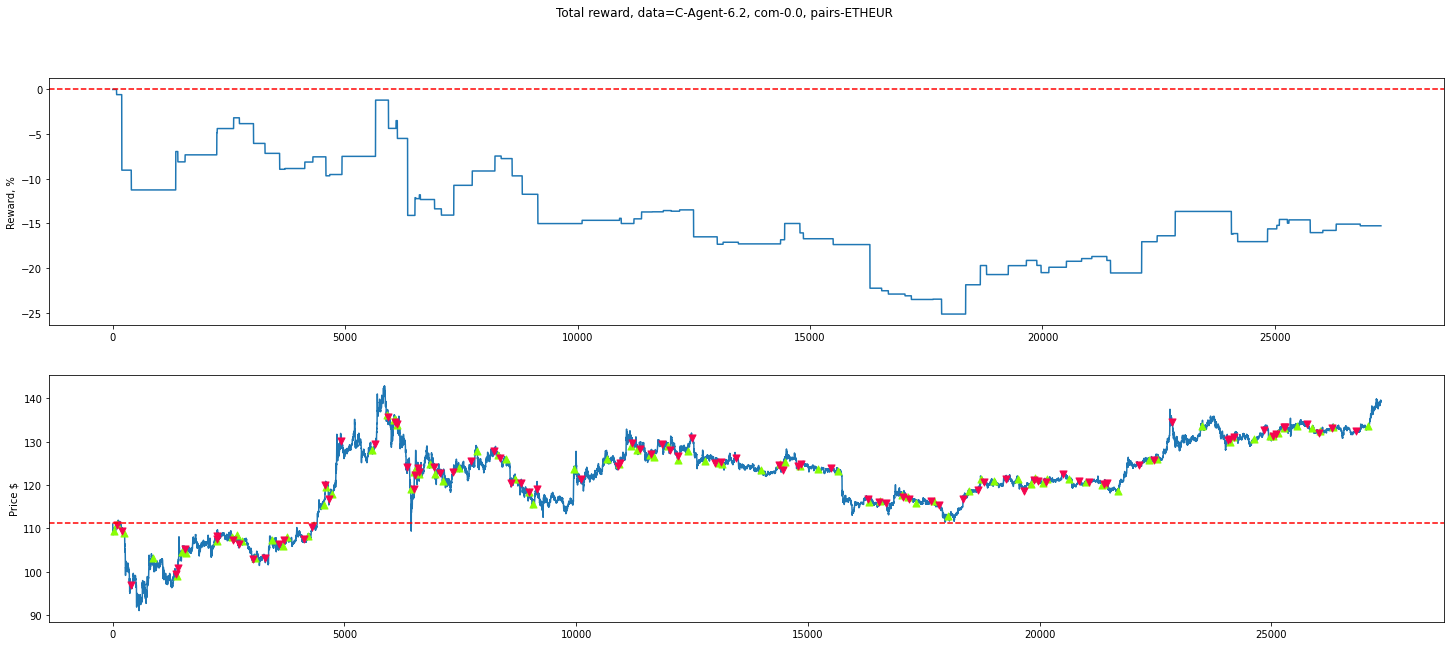

In [19]:
# Plot single network with price graph with indicators for buys and sells
plt.clf()

fig, axs = plt.subplots(2)

axs[0].plot(rewards)
axs[0].axhline(y=0, linestyle='--', color='r')
fig.suptitle(f"Total reward, data={OUTPUT_NAME}")
axs[0].set(ylabel="Reward, %")

df = list(test_data_dfs.values())[0]
buys = df.iloc[buy_idxs]
sells = df.iloc[sell_idxs]
axs[1].plot(df['close'], zorder=-1)
axs[1].scatter(buys.index.values.tolist(), buys['close'], marker='^', color='xkcd:lime green', s=50)
axs[1].scatter(sells.index.values.tolist(), sells['close'], marker='v', color='xkcd:pink red', s=50);
axs[1].set(ylabel="Price $")
axs[1].axhline(y=df['open'].iloc[0], linestyle='--', color='r')

plt.savefig(f"rewards-{OUTPUT_NAME}-{datetime.now()}.png");